<a href="https://colab.research.google.com/github/KeitaW/Colab-Notebooks/blob/master/210529_nichidai_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 課題内容
図1の散布図のように，$0.5 \leq |x -1|, |y -1| \leq 1$の範囲の値をとる変量$x, y$で表される2種類のサンプルが多数ある. それぞれの種類のらしさをうまく表すニューラルネットワークを実際に1つ作ってみなさい.

# 準備
## 必要なライブラリのインストール/インポート

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## データの生成

In [2]:
def rand(size, a=0, b=1):
    return (b - a) * np.random.random(size) + a

def generate_cluster(x_range=(0, 0.5), y_range=(0, 0.5), npoints=100, label=1):
    return np.array([
                  rand(npoints, *x_range), 
                  rand(npoints, *y_range)
            ]).T, np.ones(npoints) * label

npoints = 100
data1, data1_label = generate_cluster(x_range=(1.5, 2.0), y_range=(1.5, 2.0), npoints=npoints, label=1)
data2, data2_label = generate_cluster(x_range=(1.5, 2.0), y_range=(0.0, 0.5), npoints=npoints, label=2)
data3, data3_label = generate_cluster(x_range=(0.0, 0.5), y_range=(0.0, 0.5), npoints=npoints, label=1)
data4, data4_label = generate_cluster(x_range=(0.0, 0.5), y_range=(1.5, 2.0), npoints=npoints, label=2)

In [3]:
X = np.concatenate((data1, data3, data2, data4)) 
y = np.concatenate((data1_label, data3_label, data2_label, data4_label))
data_df = pd.DataFrame({
    "x": X[:, 0],
    "y": X[:, 1],
    "label": y
})

## 色々なニューロンを実装するための雛形となるクラスを用意する

In [4]:
class Neuron:
    def __init__(self, W, bias, layers=None):
        self.W = W
        self.bias = bias
        self.layers = layers # Neuronのリストのリスト．入力層から順に並んでいる
    def forward(self, X):
        Z = X
        if self.layers is not None:
            for layer in self.layers:
                Z = np.array([list(neuron.forward(Z)) for neuron in layer]).T
        return np.maximum(np.dot(self.W,  Z.T) + self.bias, 0)[0]

In [5]:
def check_activation(neuron, label):
    """各クラスタ中のデータに対してニューロンがどのように活動するかを可視化する関数
    """
    plt.title(f"activation of {label} neuron")
    plt.scatter(np.ones(npoints), neuron.forward(data1), label="data1")
    plt.scatter(np.ones(npoints)*1.1, neuron.forward(data2), label="data2")
    plt.scatter(np.ones(npoints)*1.2, neuron.forward(data3), label="data3")
    plt.scatter(np.ones(npoints)*1.3, neuron.forward(data4), label="data4")
    plt.xlabel("Cluster")
    plt.ylabel("Activation")
    plt.xticks([])
    plt.legend()

In [6]:
sample_neuron = Neuron(
    W=np.array([[0.1, 0.1]]),
    bias=0.5
)

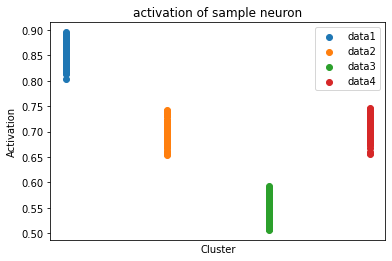

In [7]:
check_activation(sample_neuron, "sample")

# 解答例１
ここではデータ中の各クラスタに下の通り1から4の番号をふって区別する．また，$0.0 \leq x \leq 0.5$，$1.5 \leq x \leq 2$の範囲をそれぞれ$x_\rm{small}$，$x_\rm{large}$，
$0.0 \leq y \leq 0.5$，$1.5 \leq y \leq 2$をそれぞれ$y_\rm{small}$，$y_\rm{large}$と呼ぶことにする

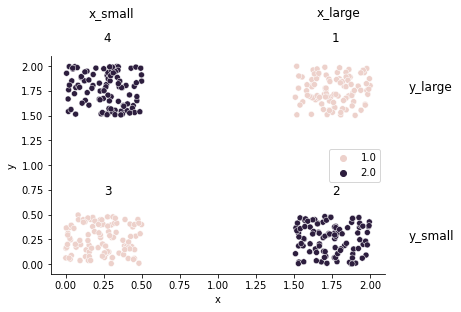

In [8]:
fig, ax = plt.subplots()
sns.scatterplot(x="x", y="y", data=data_df, hue="label", ax=ax)
ax.text(1.75, 2.25, "1", fontsize=12)
ax.text(1.75, 0.7, "2", fontsize=12)
ax.text(0.25, 0.7, "3", fontsize=12)
ax.text(0.25, 2.25, "4", fontsize=12)
ax.text(1.65, 2.5, "x_large", fontsize=12)
ax.text(0.15, 2.5, "x_small", fontsize=12)
ax.text(2.25, 0.25, "y_small", fontsize=12)
ax.text(2.25, 1.75, "y_large", fontsize=12)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.legend(loc="center right")


この解答例ではまず，$x_\rm{small}$，$x_\rm{large}$, $y_\rm{small}$, $y_\rm{large}$それぞれに属するデータを入力されたときに0でない活動を示すニューロンを第一層に用意し，その次の層にそれらの出力を利用して各クラスタを識別するニューロンを配置する．そして出力層でクラスタをまとめ上げてグループ1とグループ２を識別する．

In [9]:
# x_largeに対して0でない活動をするニューロン
x_large_neuron = Neuron(
    W=np.array([[0.5, 0.0]]),
    bias = -0.5
)

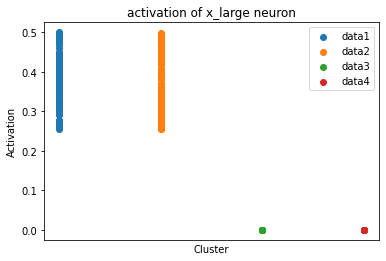

In [10]:
check_activation(x_large_neuron, "x_large")

In [11]:
# x_small
x_small_neuron = Neuron(
    W=np.array([[-0.5, 0.0]]),
    bias = 0.5
)

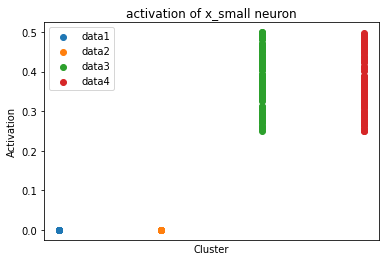

In [12]:
check_activation(x_small_neuron, "x_small")

In [13]:
y_large_neuron = Neuron(
    W=np.array([[0.0, 0.5]]),
    bias = -0.5
)

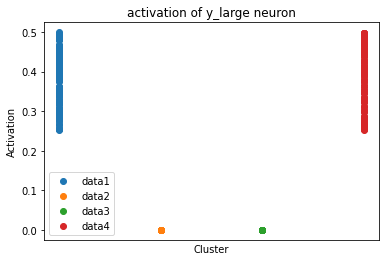

In [14]:
check_activation(y_large_neuron, "y_large")

In [15]:
y_small_neuron = Neuron(
    W=np.array([[0.0, -0.5]]),
    bias = 0.5
)

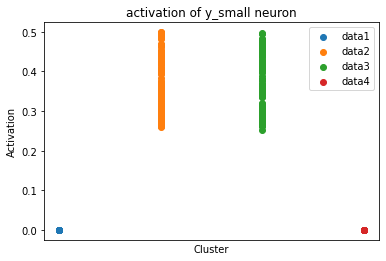

In [16]:
check_activation(y_small_neuron, "y_small")

In [17]:
layer1 = [[x_small_neuron, x_large_neuron, y_small_neuron, y_large_neuron]]

In [18]:
data1_neuron = Neuron(
    W=np.array([[0.0, 0.5, 0.0, 0.5]]),
    bias=-0.25,
    layers =layer1
)

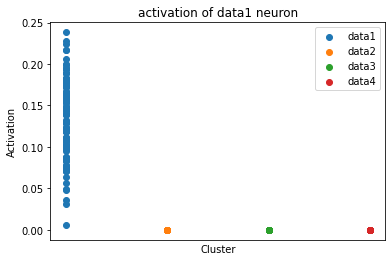

In [19]:
check_activation(data1_neuron, "data1")

In [20]:
data2_neuron = Neuron(
    W=np.array([[0.0, 0.5, 0.5, 0.0]]),
    bias=-0.25,
    layers =layer1
)

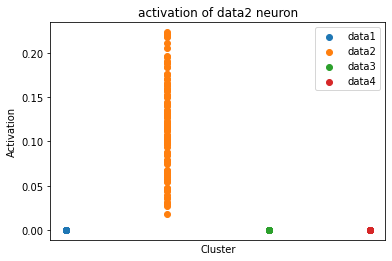

In [21]:
check_activation(data2_neuron, "data2")

In [22]:
 data3_neuron = Neuron(
    W=np.array([[0.5, 0.0, 0.5, 0.0]]),
    bias=-0.25,
    layers =layer1
)

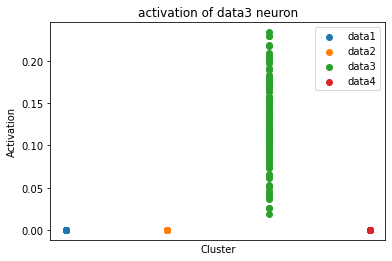

In [23]:
check_activation(data3_neuron, "data3")

In [24]:
data4_neuron = Neuron(
    W=np.array([[0.5, 0.0, 0.0, 0.5]]),
    bias=-0.25,
    layers =layer1
)

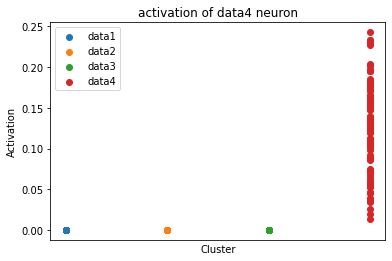

In [25]:
check_activation(data4_neuron, "data4")

In [26]:
layer2 = [[data1_neuron, data2_neuron, data3_neuron, data4_neuron]]

In [27]:
group1_neuron = Neuron(
    W=np.array([[0.5, 0.0, 0.5, 0.0]]),
    bias=0.0,
    layers = layer2
)

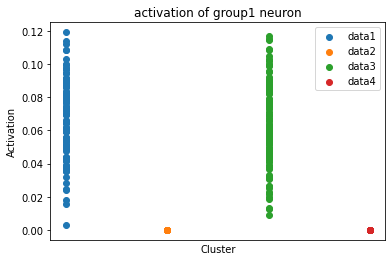

In [28]:
check_activation(group1_neuron, "group1")

In [29]:
group2_neuron = Neuron(
    W=np.array([[0.0, 0.5, 0.0, 0.5]]),
    bias=0.0,
    layers = layer2
)

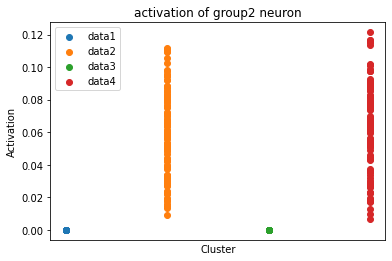

In [30]:
check_activation(group2_neuron, "group2")

![](https://github.com/KeitaW/Colab-Notebooks/raw/master/ans1.png)

## 解答2
この解答例では，下の図に示すとおり，$0.0 \leq x 0.5$，$1.5 \leq x \leq 2.0$をそれぞれ$x=\rm{False}, x=\rm{True}$，$0.0 \leq y 0.5$，$1.5 \leq y \leq 2.0$をそれぞれ$y=\rm{False}, y=\rm{True}$と読み替える．このとき種類１のデータは$x=\rm{True}, y=\rm{True}$ないし$x =\rm{False}, y=\rm{False} $に属することがわかる．

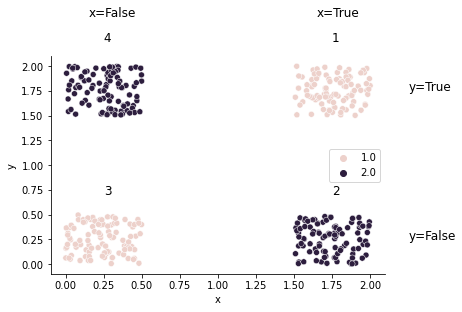

In [31]:
fig, ax = plt.subplots()
sns.scatterplot(x="x", y="y", data=data_df, hue="label", ax=ax)
ax.text(1.75, 2.25, "1", fontsize=12)
ax.text(1.75, 0.7, "2", fontsize=12)
ax.text(0.25, 0.7, "3", fontsize=12)
ax.text(0.25, 2.25, "4", fontsize=12)
ax.text(1.65, 2.5, "x=True", fontsize=12)
ax.text(0.15, 2.5, "x=False", fontsize=12)
ax.text(2.25, 0.25, "y=False", fontsize=12)
ax.text(2.25, 1.75, "y=True", fontsize=12)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.legend(loc="center right")

このように読み替えると，この識別は，実は下の真理値表で動作が定義されるXORゲートによって実現できることがわかる．

| $x$ 	| $y$ 	| $x \oplus y$  &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;	|
|-----	|-----	|--------------	|
| 0   	| 0   	| 0            	|
| 0   	| 1   	| 1            	|
| 1   	| 0   	| 1            	|
| 1   	| 1   	| 0            	|

真理値表中の0はFalse，1はTrue，$\oplus$はXORを表す．

実はこのゲートは単一のニューロンでは表現できないことが知られている．そこで，ここではより基本的な論理ゲートであるAND, OR，NANDをまず単一のニューロンを用いて実装し，それらのニューロンを組み合わせることで XORゲートを実装することを目指す

In [32]:
class Neuron:
    def __init__(self, W, bias, layers=None):
        self.W = W
        self.bias = bias
        self.layers = layers # Neuronのリストのリスト．入力層から順に並んでいる
    def forward(self, X):
        Z = X
        if self.layers is not None:
            for layer in self.layers:
                Z = np.array([list(neuron.forward(Z)) for neuron in layer]).T
        return np.sign(np.maximum(np.dot(self.W,  Z.T) + self.bias, 0)[0])

上記のようにNeuronクラスに少しだけ変更を加える．ここで扱いたいのは真理値$（0, 1）$なのでニューロンの出力を，受け取った入力の合計の符号で表す．例えば入力の合計がそれぞれ$0, 0.1$ならば出力は$0, 1$となる． 

### AND ニューロンの実装

| $x$ 	| $y$ 	| $x \cdot y$  &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;	|
|-----	|-----	|--------------	|
| 0   	| 0   	| 0            	|
| 0   	| 1   	| 0            	|
| 1   	| 0   	| 0            	|
| 1   	| 1   	| 1            	|


In [33]:
and_neuron = Neuron(
    W=np.array([[0.5, 0.5]]),
    bias=-1.25
)

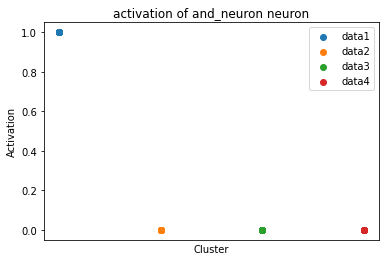

In [34]:
check_activation(and_neuron, "and_neuron")

### OR ニューロンの実装

| $x$ 	| $y$ 	| $x + y$  &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;	|
|-----	|-----	|--------------	|
| 0   	| 0   	| 0            	|
| 0   	| 1   	| 1            	|
| 1   	| 0   	| 1            	|
| 1   	| 1   	| 1            	|


In [35]:
or_neuron = Neuron(
    W=np.array([[0.5,0.5]]),
    bias=-0.75
)

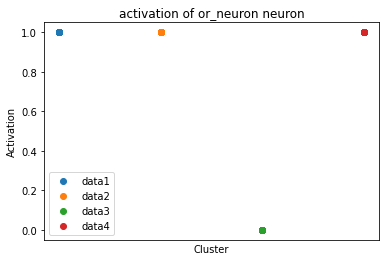

In [36]:
check_activation(or_neuron, "or_neuron")

### NAND ニューロンの実装

| $x$ 	| $y$ 	| $\overline{x \cdot y}$  &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;	|
|-----	|-----	|--------------	|
| 0   	| 0   	| 1            	|
| 0   	| 1   	| 1            	|
| 1   	| 0   	| 1            	|
| 1   	| 1   	| 0            	|

これをニューラルネットワークで実装する．

In [37]:
nand_neuron = Neuron(
    W=np.array([[-0.5, -0.5]]),
    bias=1.25
)

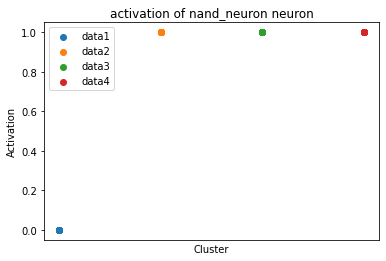

In [38]:
check_activation(nand_neuron, "nand_neuron")

In [39]:
layer1 = [[nand_neuron, or_neuron]]

### 種類1らしさを表すニューロン

下記の真理値表を見ると，実はXOR（$\oplus$）はNANDとORをANDで組み合わせると得ることができることがわかる．

| $x$ 	| $y$ 	| &nbsp; &nbsp; $\overline{x \cdot y}$ &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;	| $x + y$ &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;| $x \oplus y = \overline{x \cdot y} \cdot (x + y)$  &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;	|
|-----	|-----	|------------------	|---------	|-----------------------------------------------	|
| 0   	| 0   	| 1                	| 0       	| 0                                             	|
| 0   	| 1   	| 1                	| 1       	| 1                                             	|
| 1   	| 0   	| 1                	| 1       	| 1                                             	|
| 1   	| 1   	| 0                	| 1       	| 0                                             	|

In [40]:
xor_neuron = Neuron(
    W=np.array([[0.5, 0.5]]),
    bias=-0.5,
    layers=layer1
)

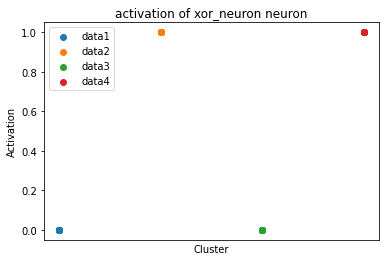

In [41]:
check_activation(xor_neuron, "xor_neuron")

このようにXORニューロンを用いることで種類1（data1とdata3）と種類2（data2とdata4）を弁別できることがわかる．

In [42]:
nxor_neuron = Neuron(
    W=np.array([[-0.5, -0.5]]),
    bias=1.0,
    layers=layer1
)

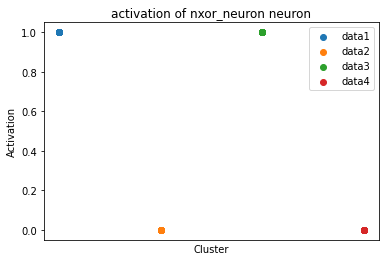

In [43]:
check_activation(nxor_neuron, "nxor_neuron")

![](https://github.com/KeitaW/Colab-Notebooks/raw/master/ans2.png)

実はコンピュータの任意の計算はNANDの組み合わせで表現することができる．
https://wwws.kobe-c.ac.jp/deguchi/sc180/logic/gate.html

このNANDがNeural Networkによって表現できるということは，Neural Networkによって「任意の論理計算を実現できる」ことを意味する．つまりNeural Networkは我々が普段用いているコンピュータと同等の計算能力を（原理的には）備えていることがわかる．

ただしこれは，授業中で述べた，"Neural Networkが任意の関数を表現できる"ということの特別な場合を述べたに過ぎない．


なお，ここで述べたネットワーク以外にも問題を解けるネットワークは無数に存在する． 余裕があれば自分の解答の重みをここで記したようにプログラム上で動作させて問題が解けるか確認してみてほしい．